## Modeling for predicting 72h ED revisit at ED discharge

Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/My Drive/ISSS623_2024-main/Group_Project/Self_Learning-MIMIC/')
path = '/content/drive/My Drive/ISSS623_2024-main/Group_Project/Self_Learning-MIMIC/'

In [4]:
import os
import time
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import load_model
from helpers_for_tasks import PlotROCCurve, get_lstm_data_gen

df_train = pd.read_csv((os.path.join(path, 'train2.csv')))
df_test = pd.read_csv((os.path.join(path, 'test2.csv')))
confidence_interval = 95
random_seed = 0

In [5]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
df_train.head()

,index,subject_id,hadm_id,stay_id,intime_ed,outtime_ed,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,race,edregtime,edouttime,insurance,in_year,age,before_ed_mortality,outcome_hospitalization,outcome_inhospital_mortality,ed_death,ed_los,intime_icu,outtime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,...,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,273532,18971123,21753872.0,37200982,2149-07-15 22:41:00,2149-07-16 06:27:00,45.0,F,2149.0,NaN,2149-07-16 04:10:00,2149-07-28 18:37:00,NaN,WHITE,2149-07-15 22:41:00,2149-07-16 06:27:00,Other,2149,45.0,False,True,False,False,0 days 07:46:00,NaN,NaN,NaN,False,False,0,1,1,2149-08-01 14:27:00,16 days 08:00:00,False,0,0,0,0,0,0,7.77,NaN,16.33,37.444444,102.0,19.0,100.0,133.0,88.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.333333,72.0,16.0,100.0,165.0,105.0,0.0,3.0,1.0,103.000000,0,0,2,1,1,2
1,253777,15439233,NaN,31867345,2159-12-20 19:43:00,2159-12-20 19:59:00,18.0,M,2159.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2159,18.0,False,False,False,False,0 days 00:16:00,NaN,NaN,NaN,False,False,0,0,0,2160-02-11 01:14:00,52 days 05:15:00,False,0,0,0,0,0,0,0.27,NaN,52.22,37.111111,70.0,20.0,99.0,151.0,64.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.666667,60.0,16.0,100.0,132.0,70.0,7.0,1.0,0.0,93.000000,0,0,0,0,0,1
2,365291,15341533,NaN,30037900,2171-09-02 21:24:00,2171-09-02 21:27:00,40.0,F,2171.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2171,40.0,False,False,False,False,0 days 00:03:00,NaN,NaN,NaN,False,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,0.05,NaN,NaN,37.555556,97.0,16.0,97.0,120.0,70.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.555556,95.0,18.0,98.0,113.0,67.0,0.0,0.0,0.0,86.666667,0,0,0,1,1,1
3,76261,13512582,NaN,38777853,2131-11-08 22:59:00,2131-11-08 23:04:00,70.0,F,2131.0,NaN,NaN,NaN,NaN,HISPANIC/LATINO - PUERTO RICAN,NaN,NaN,NaN,2131,70.0,False,False,False,False,0 days 00:05:00,NaN,NaN,NaN,False,False,0,0,0,2137-11-14 18:47:00,2197 days 19:43:00,False,0,0,0,0,0,0,0.08,NaN,2197.82,37.000000,58.0,16.0,100.0,155.0,44.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.111111,51.0,18.0,96.0,173.0,63.0,2.0,3.0,2.0,81.000000,3,13,7,0,0,1
4,99718,17758321,NaN,35942414,2115-06-25 13:15:00,2115-06-25 13:38:00,50.0,M,2115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2115,50.0,False,False,False,False,0 days 00:23:00,NaN,NaN,NaN,False,False,1,1,1,NaN,NaN,False,0,0,0,0,0,0,0.38,NaN,NaN,36.555556,72.0,16.0,96.0,187.0,108.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.777778,62.0,16.0,100.0,161.0,99.0,0.0,1.0,2.0,134.333333,1,0,5,0,0,1


### 1. task-specific filter: exclude ED death cases for train and test

In [6]:
df_train = df_train[(df_train['before_ed_mortality'] == False) & (df_train['outcome_hospitalization'] == False) & (df_train['ed_death'] == False)]
df_test = df_test[(df_test['before_ed_mortality'] == False) & (df_test['outcome_hospitalization'] == False) & (df_test['ed_death'] == False)].reset_index()

### 2. Variable Selection

In [7]:
variable = ["age", "gender",

            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d",
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d",

            "triage_pain", "triage_acuity",

            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough",
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope",
            "chiefcom_dizziness",

            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", "cci_Pulmonary",
            "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", "cci_DM2",
            "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", "cci_Cancer2",
            "cci_HIV",

            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2",
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy",
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs", "eci_Psychoses", "eci_Depression",

            "ed_temperature_last", "ed_heartrate_last", "ed_resprate_last",
            "ed_o2sat_last", "ed_sbp_last", "ed_dbp_last", "ed_los", "n_med", "n_medrecon"]

outcome = "outcome_ed_revisit_3d"

In [8]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [9]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_los,n_med,n_medrecon
0,float64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,object,float64,float64


In [10]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [11]:
X_train['ed_los'] = pd.to_timedelta(X_train['ed_los']).dt.seconds / 60
X_test['ed_los'] = pd.to_timedelta(X_test['ed_los']).dt.seconds / 60

In [12]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.04750162232316677 : 1


### 3.  Modeling script

In [13]:
# Containers for all results
result_list = []

Logistic Regression:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 10.187607049942017 seconds
AUC: 0.6922577794278508
AUPRC: 0.15952032217830855
Sensitivity: 0.5979284369114878
Specificity: 0.676792716455582
Score thresold: 0.04189262338058778
2.5 97.5


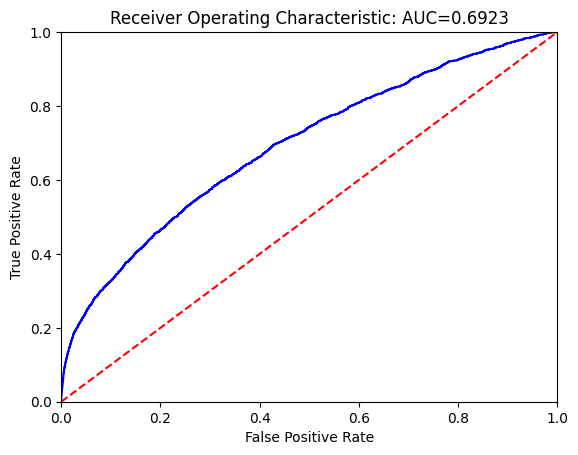

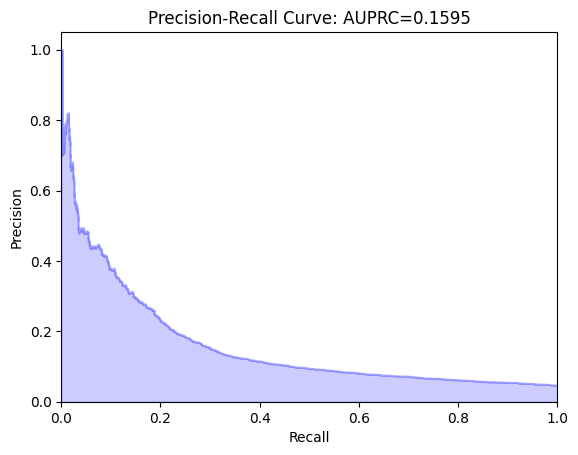

In [14]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



RandomForest:
Training time: 62.68590569496155 seconds
AUC: 0.662190848978682
AUPRC: 0.15126065021434676
Sensitivity: 0.6162900188323918
Specificity: 0.6166899535764186
Score thresold: 0.05
2.5 97.5


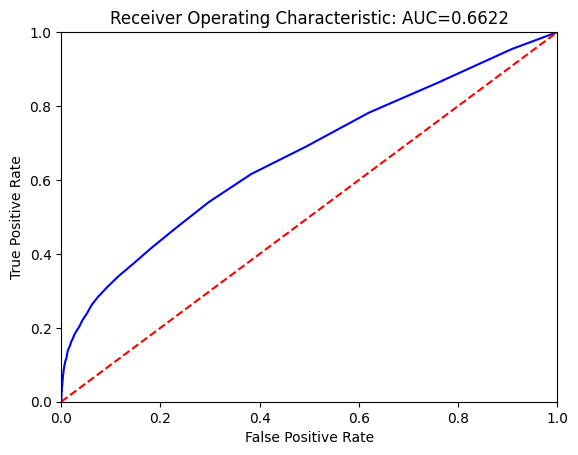

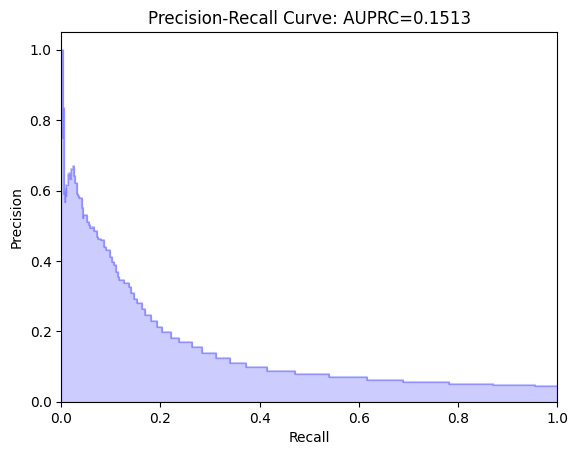

[0.08398892 0.01420481 0.01954592 0.02466482 0.03536547 0.00982037
 0.01253796 0.02091449 0.         0.         0.         0.04285669
 0.02250891 0.00542676 0.00885821 0.00574059 0.0002845  0.00565973
 0.00265618 0.00421335 0.00307347 0.0017069  0.00318253 0.0030772
 0.00290343 0.00264145 0.00289308 0.00122294 0.00646039 0.00200619
 0.00180784 0.00420444 0.00515281 0.0027197  0.00147004 0.00283342
 0.00351503 0.00159688 0.00162612 0.00165258 0.00494551 0.00241781
 0.002461   0.00289321 0.00673977 0.00450573 0.00395487 0.0010822
 0.00346455 0.00483734 0.0032396  0.00539697 0.00153347 0.00372304
 0.00591933 0.00487087 0.00341335 0.00626948 0.06710279 0.07773508
 0.03804924 0.0388582  0.07955035 0.07710689 0.08416445 0.03896378
 0.05180704]


In [15]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier()
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 60.46421480178833 seconds
AUC: 0.7037127098569878
AUPRC: 0.16796571579085307
Sensitivity: 0.597457627118644
Specificity: 0.6919817911389552
Score thresold: 0.040841213504863236
2.5 97.5


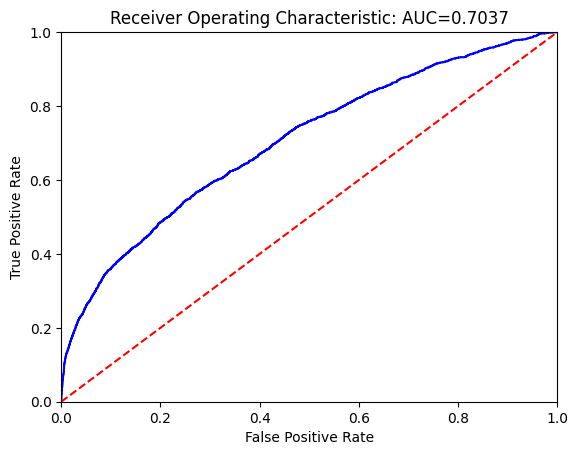

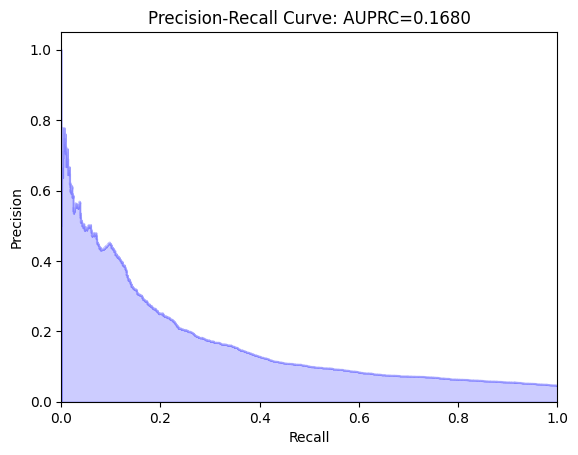

In [16]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [17]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [18]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')},
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('72h_ed_revisit_mlp')

Epoch 1/20
929/929 [==============================] - 7s 4ms/step - loss: 0.1992 - accuracy: 0.9530 - auc: 0.6145 - auprc: 0.1067 - true_positives: 350.0000 - true_negatives: 176560.0000 - precision: 0.3483 - recall: 0.0416
Epoch 2/20
929/929 [==============================] - 3s 4ms/step - loss: 0.1792 - accuracy: 0.9545 - auc: 0.6396 - auprc: 0.1299 - true_positives: 321.0000 - true_negatives: 176865.0000 - precision: 0.4784 - recall: 0.0381
Epoch 3/20
929/929 [==============================] - 4s 4ms/step - loss: 0.1760 - accuracy: 0.9548 - auc: 0.6492 - auprc: 0.1376 - true_positives: 309.0000 - true_negatives: 176926.0000 - precision: 0.5167 - recall: 0.0367
Epoch 4/20
929/929 [==============================] - 5s 5ms/step - loss: 0.1737 - accuracy: 0.9546 - auc: 0.6620 - auprc: 0.1432 - true_positives: 290.0000 - true_negatives: 176918.0000 - precision: 0.4940 - recall: 0.0344
Epoch 5/20
929/929 [==============================] - 4s 4ms/step - loss: 0.1726 - accuracy: 0.9549 - au

MLP:
1454/1454 [==============================] - 2s 1ms/step
AUC: 0.6980392311644464
AUPRC: 0.16590126932078214
Sensitivity: 0.6228813559322034
Specificity: 0.6527921755983234
Score thresold: 0.046430524
2.5 97.5


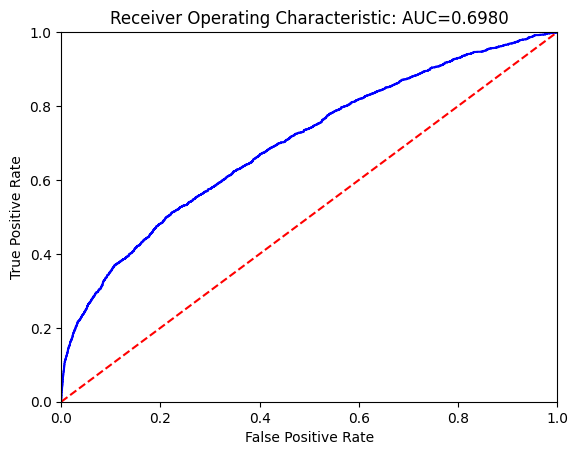

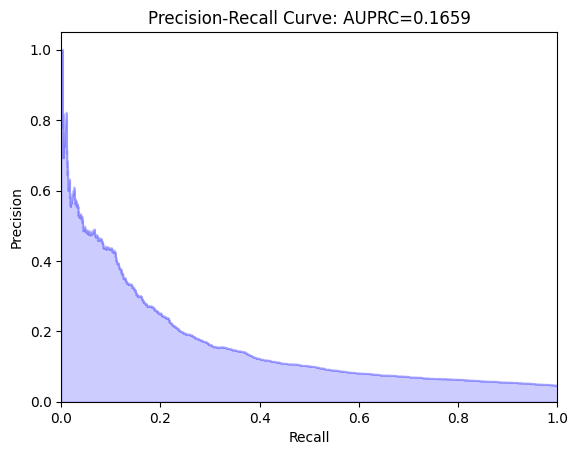

In [19]:
print("MLP:")
#mlp = load_model('72h_ed_revisit_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 4. Performance output

In [20]:
#result_df = pd.read_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task3.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.042,0.692 (0.681-0.704),0.16 (0.147-0.175),0.598 (0.58-0.662),0.677 (0.628-0.684),10.188
1,RF,0.050,0.662 (0.652-0.678),0.151 (0.141-0.168),0.616 (0.544-0.64),0.617 (0.614-0.703),62.686
2,GB,0.041,0.704 (0.695-0.717),0.168 (0.156-0.181),0.597 (0.577-0.631),0.692 (0.657-0.715),60.464
3,MLP,0.046,0.698 (0.687-0.711),0.166 (0.156-0.182),0.623 (0.6-0.656),0.653 (0.611-0.686),84.106


In [21]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_72h_ed_revisit_disposition.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
64,ed_los,0.084164
0,age,0.083989
62,ed_sbp_last,0.079550
59,ed_heartrate_last,0.077735
63,ed_dbp_last,0.077107
58,ed_temperature_last,0.067103
66,n_medrecon,0.051807
11,triage_pain,0.042857
65,n_med,0.038964
61,ed_o2sat_last,0.038858
